In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os
from scipy.stats import ttest_ind, mannwhitneyu

## Задание 1

In [4]:
df = Getch('''select user_id, exp_group,
countIf(user_id, action='view') as view_cnt, 
countIf(user_id, action='like') as like_cnt, 
countIf(user_id, action='like')/countIf(user_id, action='view') as ctr 
from simulator_20211220.feed_actions 
where toDate(time) between '2021-12-08' and '2021-12-14'
and exp_group in (2,3)
group by user_id, exp_group
''').df

In [5]:
def get_p_values(ctr_data, group1, group2, n):
    p_values = []
    for i in range(n):
        resample_1 = df[df.exp_group==group1].sample(n=500, replace=True)
        resample_2 = df[df.exp_group==group2].sample(n=500, replace=True)
        p_value = ttest_ind(resample_1.ctr,resample_2.ctr, equal_var=False)
        p_values.append(p_value.pvalue)
    
    
    sns.displot(p_values, bins=100, color='navy').set(title='P-values')
    
    p_value_share = sum(1 for i in p_values if i<=0.05)/len(p_values)
    if p_value_share <= 0.06:
        msg = 'Система сплитования работает корректно, группы неоднородны в ' + str(round(p_value_share*100,2)) + '% случаев'
    else:
        msg = 'Система сплитования работает некорректно, группы неоднородны в ' + str(round(p_value_share*100,2)) + '% случаев'
        
    print(msg)

Система сплитования работает корректно, группы неоднородны в 5.13% случаев


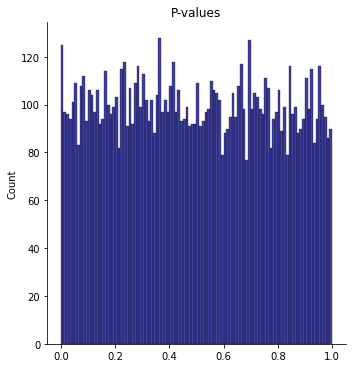

In [6]:
get_p_values(df, 2, 3, 10000)

## Задание 2

In [7]:
df = Getch('''select user_id, exp_group,
countIf(user_id, action='view') as view_cnt, 
countIf(user_id, action='like') as like_cnt, 
countIf(user_id, action='like')/countIf(user_id, action='view') as ctr 
from simulator_20211220.feed_actions 
where toDate(time) between '2021-12-29' and '2022-01-04'
and exp_group in (0,1)
group by user_id, exp_group
''').df

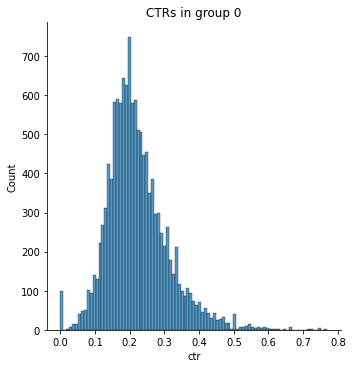

In [8]:
sns.displot(df[df.exp_group==0].ctr).set(title='CTRs in group 0')

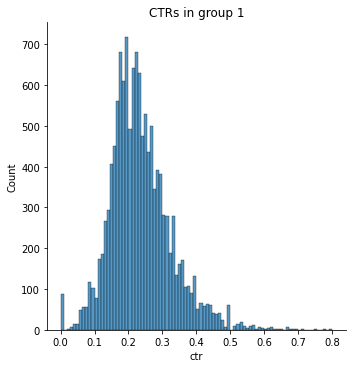

In [9]:
sns.displot(df[df.exp_group==1].ctr).set(title='CTRs in group 1')

#### Let's smooth it!

In [10]:
def get_smoothed_ctr(like_cnt, view_cnt, global_ctr, alpha):
    ctr_smoothed = (like_cnt + alpha*global_ctr) / (view_cnt + alpha)
    return ctr_smoothed

In [11]:
global_ctr = df.like_cnt.sum() / df.view_cnt.sum()
df['ctr_smoothed'] = df.apply(lambda x: get_smoothed_ctr(x['like_cnt'], x['view_cnt'], global_ctr, 5), axis=1)

#### Comparing CTR's in 2 groups

In [12]:
def check_effect(smoothed_ctr_data, group1, group2):
    p_value = ttest_ind(smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed, smoothed_ctr_data[smoothed_ctr_data.exp_group==group2].ctr_smoothed, equal_var=False).pvalue
    diff = (smoothed_ctr_data[smoothed_ctr_data.exp_group==group2].ctr_smoothed.mean() - smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed.mean()) / smoothed_ctr_data[smoothed_ctr_data.exp_group==group1].ctr_smoothed.mean() *100
    if p_value<0.05:
        msg = 'Эффект от внедрения нового алгоритма присутствует, CTR увеличился на ' + str(round(diff,2)) + '%'
    else:
        msg = 'Эффект от внедрения нового алгоритма обнаружить не удалось'
    print(msg)

In [13]:
check_effect(df, 0, 1)

Эффект от внедрения нового алгоритма присутствует, CTR увеличился на 5.97%


#### Checking secondary metric

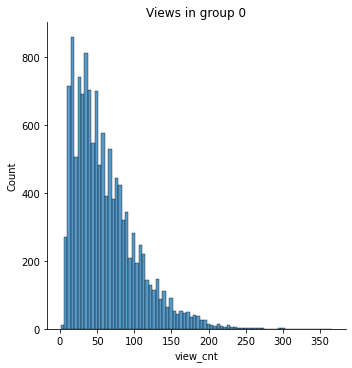

In [14]:
sns.displot(df[df.exp_group==0].view_cnt).set(title='Views in group 0')

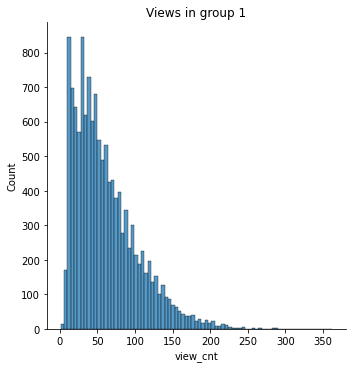

In [15]:
sns.displot(df[df.exp_group==1].view_cnt).set(title='Views in group 1')

In [16]:
def check_secondary_metric(data, group1, group2):
    p_value = mannwhitneyu(data[data.exp_group==group1].view_cnt,data[data.exp_group==group2].view_cnt).pvalue
    diff = (data[data.exp_group==group2].view_cnt.mean() - data[data.exp_group==group1].view_cnt.mean()) / data[data.exp_group==group1].view_cnt.mean() *100
    if p_value<0.05:
        msg = 'Новый алгоритм повлиял на вторичную метрику Views, она изменилась на ' + str(round(diff,2)) + '%'
    else:
        msg = 'Новый алгоритм не повлиял на значение вторичной метрики Views'
        
    print(msg)

In [17]:
check_secondary_metric(df, 0, 1)

Новый алгоритм не повлиял на значение вторичной метрики Views


Рекомендация:
    1. Внедрение нового алгоритма показало статистически значимый эффект на метрику CTR, она увеличилась на 5.97%
    2. Внедрение нового алгоритма не повлияло на просмотры - вторичную метрику АБ-тестирования
    3. Если эффект удовлетворяет требованиям к эффективности и финансовым требованиям, новый алгоритм можно использовать в проде.

## Задание 3

In [18]:
from statsmodels.stats.power import TTestIndPower

effect_size = 0.3
alpha = 0.05
power = 0.8 


analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)

print('Sample size: {:.2f}'.format(result))

Sample size: 175.38


In [19]:
n1 = len(df[df.exp_group==0])        # number of observations of sample 1
n2 = len(df[df.exp_group==1])         # number of observations of sample 2
mi1 = df[df.exp_group==0].ctr_smoothed.mean()       # mean of sample 1
mi2 = df[df.exp_group==1].ctr_smoothed.mean()     # mean of sample 2
sigma1 = df[df.exp_group==0].ctr_smoothed.std()     # standard deviation of sample 1
sigma2 = df[df.exp_group==1].ctr_smoothed.std()     # standard deviation of sample 2
alpha = 0.05   # significance level


sd_pooled = np.sqrt(((n2 - 1)*sigma2**2 + (n1 - 1)*sigma1**2)/(n1 + n2 - 2))
effect_size = (mi2 - mi1)/sd_pooled

print('Effect size: {:.2f}'.format(effect_size))

Effect size: 0.18


In [21]:
alpha = 0.05
power = 0.8 


# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample size: {:.2f}'.format(result))

Sample size: 501.42


Для получения effect size = 0.18 можно было использовать меньший объем выборки.